In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pytorch-msssim

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [5]:
from math import floor
import numpy as np
from pytorch_msssim import ms_ssim
from torchvision.models.inception import inception_v3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
inception_model = inception_v3(pretrained=True, transform_input=False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [7]:
def calculate_inception_score(images,inception_model,n_split=10, eps=1E-16):
  inception_model.eval()
  up = nn.Upsample(size=(299,299), mode='bilinear',align_corners=False)
  images = up(images)
  yhat = F.softmax(inception_model(images))
  scores = list()
  n_part = floor(images.shape[0]/n_split)
  for i in range(n_split):
    ix_start, ix_end = i * n_part, i * n_part + n_part
    p_yx = yhat[ix_start:ix_end]
    p_y = p_yx.mean(dim=0).unsqueeze(0)
    kl_d = p_yx * (p_yx.log() - p_y.log())
    sum_kl_d = kl_d.sum(dim=1)
    avg_kl_d = sum_kl_d.mean()
    score = avg_kl_d.exp()
    scores.append(score.item())
  avg = np.mean(scores)
  std = np.std(scores)
  return avg, std

In [8]:
def generate_images_calculate_IS(gen_model, target, nz, inception_model,total_number_of_images = 256):
  gen_model.to('cpu')
  
  class_target = torch.ones(total_number_of_images)*target

  with torch.no_grad():
      latent_z = torch.randn(total_number_of_images, nz)
      fake_img = gen_model(latent_z, class_target.int())

  avg, std = calculate_inception_score(fake_img,inception_model)
  print('IS avg {:.4f}, IS std {:.4f}'.format(avg, std))

  npimg = make_grid(fake_img, padding=0, nrow=16)
  fig, axes = plt.subplots(1,1, figsize=(10,10))
  axes.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  fig.show()
  
  return fake_img

In [9]:
def cal_ms_ssim(img_real,img_fake):
  up = nn.Upsample(size=(299,299), mode='bilinear',align_corners=False)
  img_real =up(img_real.type(torch.DoubleTensor))
  img_fake =up(img_fake.type(torch.DoubleTensor))

  ms_ssim_score = ms_ssim(img_fake,img_real,data_range=1,size_average=True)
  print('MS_SSIM avg {:.4f}'.format(ms_ssim_score))
  return ms_ssim_score

In [10]:
class cGenerator(nn.Module):
  def __init__(self, nz):
    super(cGenerator, self).__init__()
    self.emb = nn.Embedding(10, 10)
    self.nz=nz
    
    self.model = nn.Sequential(
      nn.Linear(self.nz+10, 128),
			nn.BatchNorm1d(128, 0.8),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Linear(128, 256),
			nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Linear(256, 512),
			nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Linear(512, 1024),
			nn.BatchNorm1d(1024, 0.8),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Linear(1024, 3*32*32),
      nn.Tanh(),
			)
    
  def forward(self, nz, class_target):
   input = torch.cat((self.emb(class_target), nz), -1)
   img = self.model(input)
   img = img.view(img.size(0), 3, 32, 32)
   return img

In [11]:
class cDiscriminator(nn.Module):
  def __init__(self,nclass,img_size=32):
    super(cDiscriminator, self).__init__()
    self.emb = nn.Embedding(10, 10)
    self.nclass = nclass
    self.img_size = img_size
    
    self.model = nn.Sequential(
        nn.Linear(3082, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(512, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(512, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True),
      
			  nn.Linear(512, 1),
			  nn.Sigmoid()
     )
    
  def forward(self, img, class_target):
    img = img.view(img.size(0),-1)
    input = torch.cat((img, self.emb(class_target)), -1)

    fc_isreal = self.model(input)
    return fc_isreal 

In [12]:
nz=100
nclass=10

lr=0.0001
iterations=50

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [13]:
def initialize_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    nn.init.constant_(m.bias.data, 0.01)

In [14]:
dis_model = cDiscriminator(nclass,img_size=32).apply(initialize_weights).to(device)
gen_model = cGenerator(nz).to(device)

label_loss=nn.BCELoss()

optD = optim.Adam(dis_model.parameters(), lr=lr)
optG = optim.Adam(gen_model.parameters(), lr=lr)

In [15]:
def training(iterations, dataloader, dis_model, gen_model, optD, optG, label_loss, nz, device):
    eval_z = torch.normal(0, 1, size=(32,nz))
    eval_z =eval_z.to(device)
    eval_label = torch.randint(0, 10, (32,)).to(device)

    for epoch in range(iterations):
        total_dis_loss=0
        total_gen_loss=0

        for img, class_target in dataloader:
            img = img.to(device)
            class_target = class_target.to(device)

            #train the discriminator
            optD.zero_grad()

            #real data is 1 and fake data is 0
            img_real_label = Variable(torch.ones(img.size()[0],1).to(device))
            img_fake_label = Variable(torch.zeros(img.size()[0],1).to(device))

            img_label_pred = dis_model(img, class_target)

            loss_label_real= label_loss(img_label_pred, img_real_label)
            loss_label_real.backward()
            optD.step()
            
            latent_z = torch.randn(img.size()[0],nz).to(device)
            class_target_fake =torch.randint(0,10, (img.size()[0],)).to(device)

            fake_img = gen_model(latent_z, class_target_fake)
            fake_img_label_pred=dis_model(fake_img.detach(), class_target_fake)

            loss_label_fake = label_loss(fake_img_label_pred, img_fake_label)
            loss_label_fake.backward()
            optD.step()

            loss_dis = (loss_label_fake+loss_label_real)/2
 
 
            #train the generator
            gen_model.zero_grad()
            fake_img_label = dis_model(fake_img, class_target)
            loss_label_gen = label_loss(fake_img_label, img_real_label)
            loss_label_gen.backward()
            optG.step()

            total_dis_loss+=loss_dis.item()
            total_gen_loss+=loss_label_real.item()

        print('Epoch {} Discriminator loss {:.2f} and Generator loss {:.2f}'.format(epoch, total_dis_loss/len(dataloader),total_gen_loss/len(dataloader)))
        with torch.no_grad():
          eval_img = gen_model(eval_z, eval_label)
          vutils.save_image(eval_img.data, "c_eval_images_{}.png".format(epoch))

        torch.save(gen_model.state_dict(), '/content/cGen_epoch_best.pth')
        torch.save(dis_model.state_dict(), '/content/cDis_epoch_best.pth')

In [16]:
training(iterations, trainloader, dis_model, gen_model, optD, optG, label_loss, nz, device)

Epoch 0 Discriminator loss 0.08 and Generator loss 0.03
Epoch 1 Discriminator loss 0.10 and Generator loss 0.06
Epoch 2 Discriminator loss 0.12 and Generator loss 0.08
Epoch 3 Discriminator loss 0.14 and Generator loss 0.09
Epoch 4 Discriminator loss 0.15 and Generator loss 0.11
Epoch 5 Discriminator loss 0.16 and Generator loss 0.11
Epoch 6 Discriminator loss 0.20 and Generator loss 0.13
Epoch 7 Discriminator loss 0.23 and Generator loss 0.15
Epoch 8 Discriminator loss 0.25 and Generator loss 0.17
Epoch 9 Discriminator loss 0.28 and Generator loss 0.18
Epoch 10 Discriminator loss 0.28 and Generator loss 0.19
Epoch 11 Discriminator loss 0.32 and Generator loss 0.21
Epoch 12 Discriminator loss 0.32 and Generator loss 0.21
Epoch 13 Discriminator loss 0.36 and Generator loss 0.23
Epoch 14 Discriminator loss 0.36 and Generator loss 0.23
Epoch 15 Discriminator loss 0.39 and Generator loss 0.24
Epoch 16 Discriminator loss 0.40 and Generator loss 0.25
Epoch 17 Discriminator loss 0.41 and Gene

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IS avg 1.4796, IS std 0.1522
MS_SSIM avg 0.0242


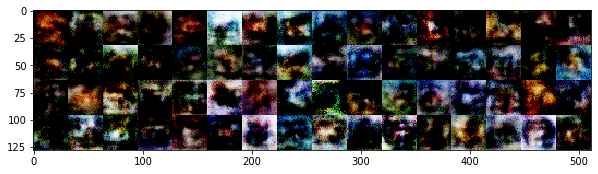

In [45]:
target=0
total_number_of_images = 64

cGen = cGenerator(nz)
cGen.load_state_dict(torch.load('/content/cGen_epoch_50.pth'))

#select a batch of target
label = np.asarray(trainset.targets)
img=np.asarray(trainset.data/255)
img_real=img[label==target][0:total_number_of_images]
img_real=torch.tensor(img_real).permute(0,3,2,1)


img_fake=generate_images_calculate_IS(cGen, target, nz, inception_model, total_number_of_images)
vutils.save_image(img_fake.data, "./c_images_fake_group_{}.png".format(target))
ms_ssim_score = cal_ms_ssim(img_real, img_fake)